# PPO with stable baseline

## Setup

In [1]:
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%cd ..
from src.microgrid_env import MicrogridEnv
from src.get_data import get_data_dict

/fp/homes01/u01/ec-felixek/pc/Documents/code/in5460-mex1


In [2]:
# Load data
data_dict = get_data_dict(k=25, region=("CA"))

# Define Microgrid Env
env = MicrogridEnv(data_dict)

/fp/homes01/u01/ec-felixek/pc/Documents/code/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
# Define the PPO agent
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO
model = PPO("MultiInputPolicy", env, verbose=1, learning_rate=0.003)

/fp/homes01/u01/ec-felixek/pc/Documents/code/venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
# Set new logger
# Logger: https://stable-baselines3.readthedocs.io/en/master/common/logger.html
logs_path = "logs/"
new_logger = configure(logs_path, ["json"])
model.set_logger(new_logger)

## Training

In [5]:
# Train the agent
total_timesteps = 800_000  # Adjust the number of training timesteps as needed
#total_timesteps = 20_000
model.learn(total_timesteps=total_timesteps, progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800,677/800,000  [ 0:14:32 < 0:00:00 , 963 it/s ]

In [6]:
# Plot loss
log_name = "progress_v4"
with open(f"logs/{log_name}.json", 'r') as file:
    data = [json.loads(line) for line in file]
loss_data_list = [{key: value for key, value in entry.items() if 'loss' in key} for entry in data]
df = pd.DataFrame(loss_data_list).iloc[1:].reset_index(drop=True)

print("Training time (min.)", data[-1]["time/time_elapsed"]/60)

Training time (min.) 14.533333333333333


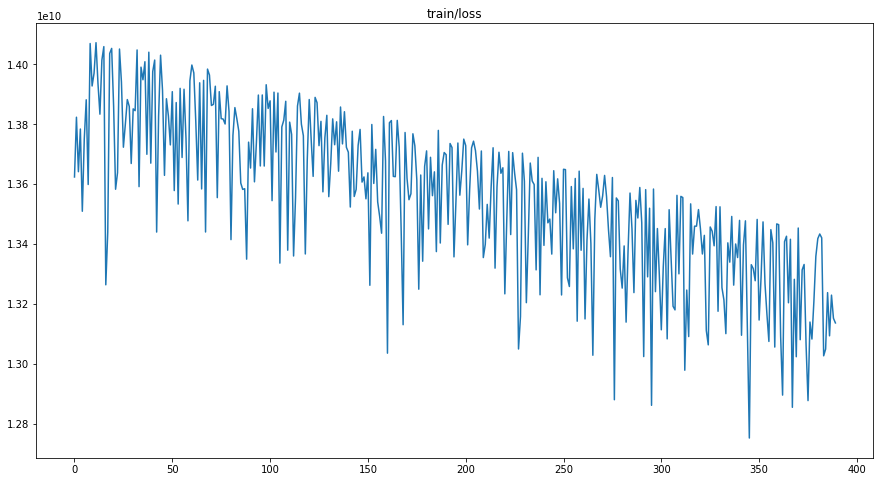

In [19]:
i = 3
df[df.columns[i]].plot(title=df.columns[i])
plt.show()

## Model saving & loading

In [8]:
# Save the trained model
model.save("models/microgrid_ppo_model_v4")

# v1 -> total_timesteps = 800_000; learning_rate=0.0003, k=25, CA
# v2 -> total_timesteps = 800_000; learning_rate=<not specified>, k=25, CA 
# v2 -> total_timesteps = 800_000; learning_rate=<not specified>, k=25, CA -> positive costs
# v2 -> total_timesteps = 800_000; learning_rate=0.003, k=25, CA

In [12]:
# Load the trained model (if needed)
#model = PPO.load("models/microgrid_ppo_model_v2")

## Testing

In [9]:
# Test the trained agent
test_episodes = 1000
max_length = len(data_dict["energy_demand"])
if test_episodes > max_length:
    raise Exception(f"episodes must be smaller { max_length }")

obs = env.reset()
step_info = []

for _ in range(test_episodes):  # Test for 1000 steps
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df = pd.DataFrame.from_dict(step_info)

## Close

In [8]:
# Close the environment when done
env.close()

## Analysis

In [10]:
step_df.head(3)

,reward,operational_cost,sell_back_reward,energy_demand,energy_load,energy_purchased,energy_battery_discharged,energy_generated_solar,solar_load,solar_battery,...,wind_sell,energy_generated_generator,generator_load,generator_battery,generator_sell,working_status,soc,solar_irradiance,wind_speed,energy_price_utility_grid
0,-9999.900714,0.256680,0.482376,20.737006,4.188171,"{'load': 0.33733904, 'battery': 1.7694881}",0.000000,3.614800e-08,1.709496,0.00000,...,0.000000,0.00,1.719223,0.437708,0.000000,"{'solar': 0, 'wind': 1, 'generator': 0}",0.285,0.1291,43.128,0.06
1,-9999.738015,0.037088,0.446816,17.710416,2.431514,"{'load': 1.1677525, 'battery': 1.2946376}",0.057617,0.000000e+00,0.225771,0.00000,...,0.000000,0.06,0.980373,0.000000,0.223408,"{'solar': 0, 'wind': 1, 'generator': 0}",0.285,0.1592,45.900,0.06
2,-9995.900838,1.725510,5.832913,16.678662,1.945212,"{'load': 0.0, 'battery': 0.1373479}",0.000000,0.000000e+00,1.897818,1.73485,...,0.280536,0.06,0.047394,0.424212,0.608086,"{'solar': 0, 'wind': 1, 'generator': 0}",0.285,0.0850,46.872,0.06


In [11]:
# Count blackouts
print("absolute:", sum(step_df.energy_demand > step_df.energy_load))
print("relative:", sum(step_df.energy_demand > step_df.energy_load) / test_episodes)

absolute: 1000
relative: 1.0


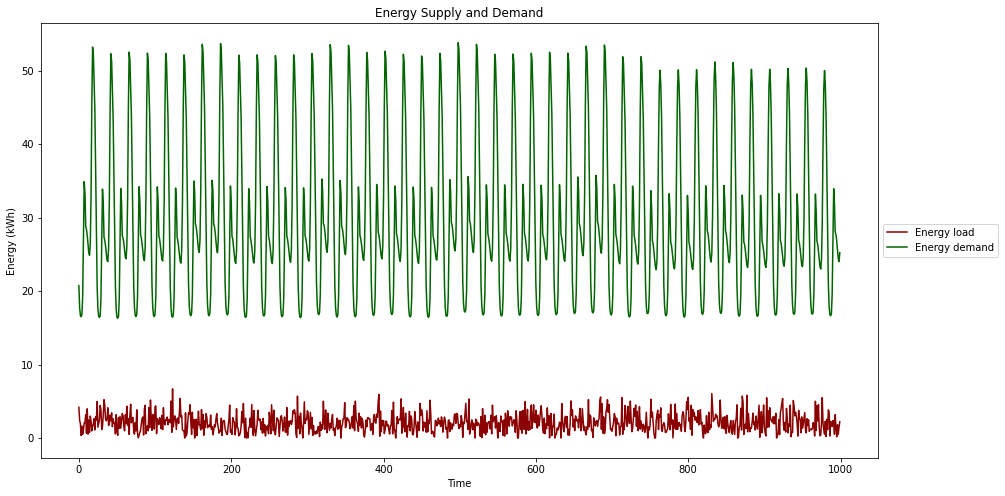

In [12]:
# Plotting energy demand and load
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(step_df['energy_load'], color='darkred', label='Energy load')
plt.plot(step_df['energy_demand'], color='darkgreen', label='Energy demand')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy Supply and Demand')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

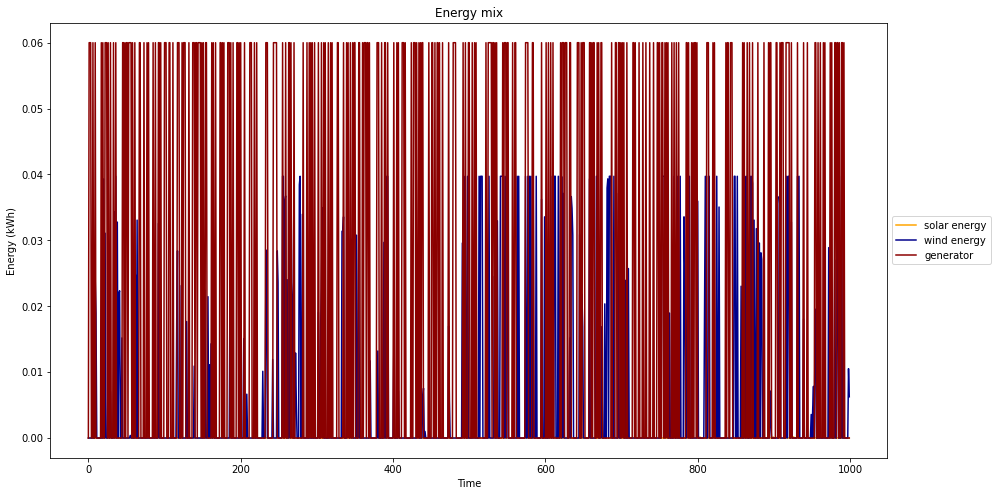

In [13]:
# Plotting energy produced
plt.plot(step_df['energy_generated_solar'], color='orange', label='solar energy')
plt.plot(step_df['energy_generated_wind'], color='darkblue', label='wind energy')
plt.plot(step_df['energy_generated_generator'], color='darkred', label='generator')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy mix')

# Moving legend outside to the right and centering
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

<Axes: >

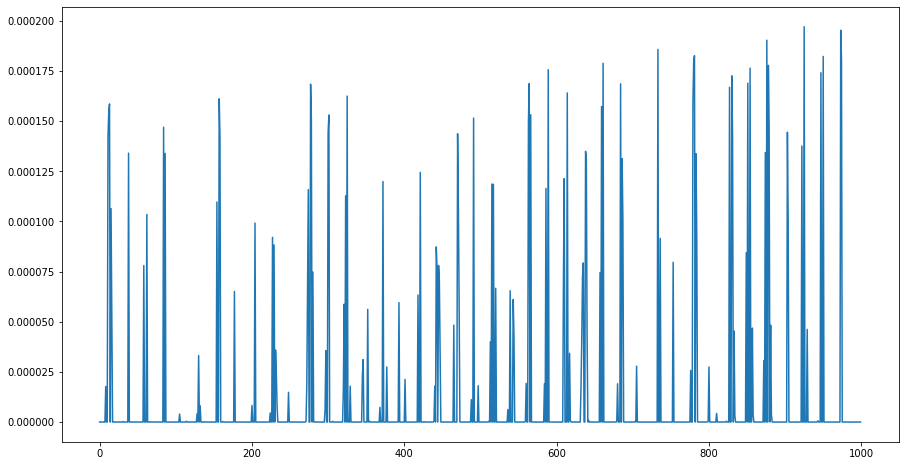

In [23]:
col = "energy_generated_solar"
step_df[col].plot()